# 3/4/21 - Experiment 3-3

## 3-3 : phase1_nlive = 200, phase1_tolerance = 0.5, phase2_nlive = 500, phase2_tolerance = 0.25, 4 Positions, Positions threshold = 1.0, use effective radius from GAMA DR3 Sersic Photometry catalog with sigma the observed error and upper limit (effective radius + error 1.3435+0.1146=1.4581), smaller mask (effective radius) centered at (0.075, -0.075), fix lens light bulge profile in second phase. Source R_E (0->10*lens.inensity)

## Don't take the instance for the ellipticity and effective radius. Set same max effective radius.

In [2]:
### libraries
%matplotlib inline
# set workspace path
from pyprojroot import here
workspace_path = str(here())#'/data/sknabel/autolens_workspace'
%cd $workspace_path
print(f"Working Directory has been set to `{workspace_path}`")

import matplotlib.pyplot as plt
from autoconf import conf
import autolens as al
import autolens.plot as aplt
import autofit as af
import pandas as pd
import numpy as np
from astropy.io import fits
from astropy.visualization import astropy_mpl_style
plt.style.use(astropy_mpl_style)
from astropy.stats import sigma_clip as clip
from os import path
import time

# set datetime variable
datetime = time.strftime("%d%m%Y-%H%M%S")

# paths
autoz_path = '/data/sknabel/autoz_lens_model/'
file_path = f'{autoz_path}files/'
csv_path = f'{file_path}csv/'
fits_path = f'{file_path}fits/'
png_path = f'{autoz_path}visuals/png/'
pdf_path = f'{autoz_path}visuals/pdf/'

/data/sknabel/autoz_lens_model
Working Directory has been set to `/data/sknabel/autoz_lens_model`


Lens and source redshifts at [0.40121394] and [0.71961558].
Einstein radius prior: 0.7818634676165951
Plotting r-band


/soft/anaconda3/lib/python3.7/site-packages/autoarray/dataset/abstract_dataset.py:88: RuntimeWarning: divide by zero encountered in true_divide
  return 1.0 / self.noise_map


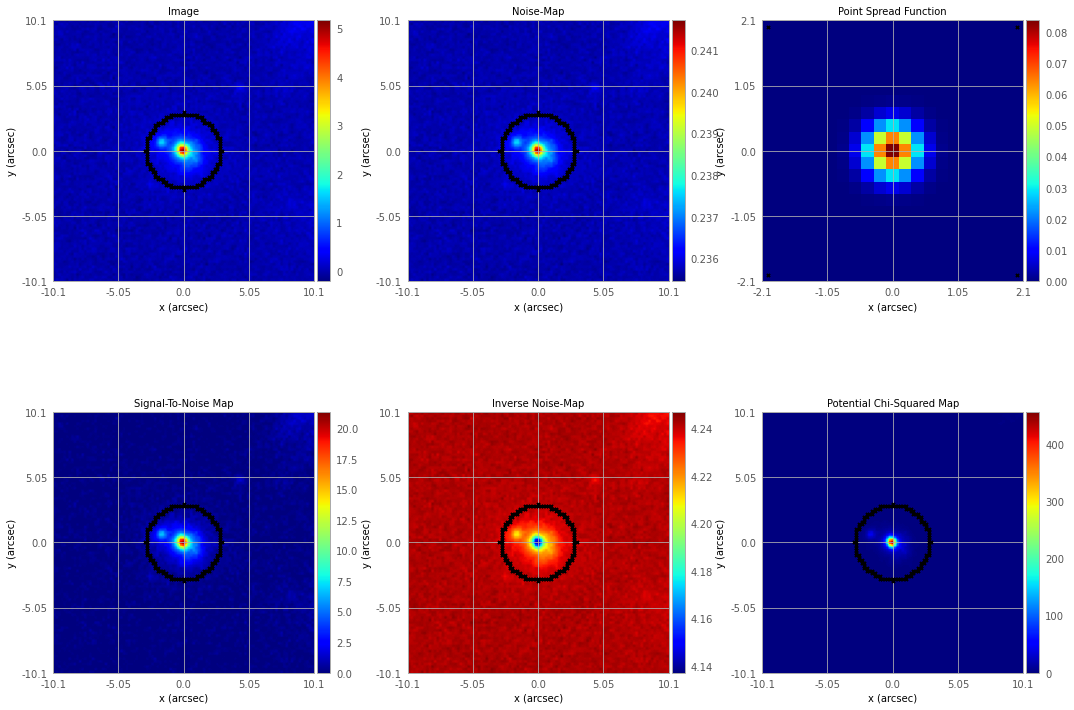

AttributeError: module 'autolens.plot' has no attribute 'show'

In [5]:
# this should be constant across experiments

gama_id = 250289
links_id = 2730

object_folder = f'{fits_path}G{gama_id}_{links_id}/'
output_folder = f'{autoz_path}output/G{gama_id}_{links_id}/'

# load object data table
links = pd.read_csv(f'{csv_path}/latest/links_sample_latest.csv')
lens_galaxy_data = links[links.GAMA_ID == gama_id]
zlens=lens_galaxy_data.zlens.values
zsource=lens_galaxy_data.zsource.values
einstein_radius=np.mean([lens_galaxy_data.theta_e_pm.values, lens_galaxy_data.theta_e_sis.values]) # take average of einstein radius estimates for prior
print(f'Lens and source redshifts at {zlens} and {zsource}.')
print(f'Einstein radius prior: {einstein_radius}')

# load r-band imaging
imaging_r = al.Imaging.from_fits(image_path=path.join(object_folder, f'{links_id}_r_image.fits'),
                              noise_map_path=path.join(object_folder, f'{links_id}_r_noisemap.fits'),
                              psf_path=path.join(object_folder, f'{links_id}_r_psf.fits'),
                               pixel_scales=0.2)

# set up mask
mask = al.Mask2D.circular(
    shape_native=imaging_r.shape_native, pixel_scales=imaging_r.pixel_scales, sub_size=2, radius=3.0
)
visuals_2d = aplt.Visuals2D(mask=mask)

# plot subplots for first view
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_r.subplot_imaging()

# load g-band imaging
# no g on this one

# set up grid and settings
settings_masked_imaging = al.SettingsMaskedImaging(grid_class=al.Grid2D)#, psf_shape_2d=imaging.psf.shape_2d)
settings = al.SettingsPhaseImaging(settings_masked_imaging=settings_masked_imaging)

#set up lens light profile
lens_start = al.GalaxyModel(
    redshift=zlens, bulge=al.lp.EllipticalSersic#, mass=al.mp.EllipticalIsothermal
)

# set priors
# lens position
lens_start.bulge.centre_0 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
lens_start.bulge.centre_1 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.1)
# effective radius
#lens_start.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=5.0) # why have I chosen 3 here? because the mask is 3...

In [ ]:
# Start a pandas dataframe
#performance_log = pd.DataFrame(columns=['Experiment', 
#                                        'phase1_time', 
#                                        'phase1_likelihood', 
#                                        'phase2_time', 
#                                        'phase2_likelihood' 
#                                        ])

# load performance log from csv
performance_log = pd.read_csv(f'{csv_path}G{gama_id}_{links_id}_performance_log.csv')
#print(performance_log)
print(performance_log)

In [ ]:
# set experiment number
experiment_number = '3-2'

lens_start.bulge.effective_radius = af.GaussianPrior(mean=1.3435, sigma=0.1146, lower_limit=0.0, upper_limit=1.4581)
lens_start.bulge.centre_0 = af.UniformPrior(lower_limit=0.0, upper_limit=0.1)
lens_start.bulge.centre_1 = af.UniformPrior(lower_limit=-0.1, upper_limit=0.0)

# set up mask
lens_mask = al.Mask2D.circular(
    shape_native=imaging_r.shape_native, pixel_scales=imaging_r.pixel_scales, sub_size=2, radius=1.3435, centre=(0.075, -0.075) 
)
visuals_2d = aplt.Visuals2D(mask=lens_mask)

# plot subplots for first view
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter(
    imaging=imaging_r, visuals_2d=visuals_2d
)
imaging_plotter_r.subplot_imaging()

# set up phase
phase1 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f"{output_folder}", name=f"experiment_{experiment_number}_phase1_{datetime}", n_live_points=200,
        evidence_tolerance=0.5, walks = 10
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens_start)#, source=source)
)

print(lens_start)

In [ ]:
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase1_result = phase1.run(dataset=imaging_r, mask=lens_mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

In [ ]:
# write the results to the log
print(f'Log likelihood: {phase1_result.log_likelihood}')
print(f'Model: {phase1_result.model}')

phase1_time = tock-tick

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase1_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()


In [ ]:
# now phase 2!

#set up lens and source

# set stellar mass/light profile
bulge = af.PriorModel(al.lmp.EllipticalSersic)
bulge.take_attributes(source=phase1_result.model.galaxies.lens.bulge)

# set dark matter profile
dark = af.PriorModel(al.mp.SphericalNFWMCRLudlow)
dark.mass_at_200 = af.LogUniformPrior(lower_limit=1e8, upper_limit=1e15)
dark.redshift_object = zlens
dark.redshift_source = zsource

lens = al.GalaxyModel(
    redshift=zlens, bulge=bulge, dark=dark
)

source = al.GalaxyModel(
    redshift=zsource, bulge=al.lp.SphericalExponential)

# make lens intensity default to 0.1 +- 0.1 because red to green makes it wonky
#lens.bulge.intensity = af.GaussianPrior(mean=0.1, sigma=0.1)

# set uniform m_l ratio
#lens.bulge.mass_to_light_ratio = af.UniformPrior(lower_limit=0.0, upper_limit=100000.0) # leave it default

# make dark matter centered at stellar mass center
lens.bulge.centre = lens.dark.centre
lens.bulge.centre = phase1_result.instance.galaxies.lens.bulge.centre

# make lens effective radius max at upper_limit=1.4581
lens.bulge.effective_radius.upper_limit=1.4581

# einstein radius
#lens.mass.einstein_radius = af.GaussianPrior(mean=einstein_radius, sigma=0.3*einstein_radius) # take sigma to be 30% of mean # hmmm

# source position
source.bulge.centre_0 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.centre_1 = af.UniformPrior(lower_limit=-3, upper_limit=3)
source.bulge.effective_radius = af.UniformPrior(lower_limit=0.0, upper_limit=5.0)
#source.bulge.intensity = af.UniformPrior(lower_limit=0.0, upper_limit=10*lens.bulge.intensity)

print(f'Lens: {lens}')
print(f'Source: {source}')

In [ ]:
# Set up the positions... (GUI is not working...)

# plot the r-band image to see it
print('Plotting r-band')
imaging_plotter_r = aplt.ImagingPlotter( # this is where the noise is coming up weird
    imaging=imaging_r, visuals_2d=aplt.Visuals2D(mask=mask)
)
imaging_plotter_r.figures(image=True)

# set positions
imaging_r.positions = al.Grid2DIrregular(
    [(0.75, -1.75), (-0.8, 1.0), (-1.0, 0.5), (0.3, 1.1)]
)

# plot the image
visuals_2d = aplt.Visuals2D(mask=mask, positions=imaging_r.positions)
imaging_plotter_r = aplt.ImagingPlotter(imaging=imaging_r, visuals_2d=visuals_2d)
imaging_plotter_r.figures(image=True)

In [ ]:
# set the settings to include the positions
settings_lens = al.SettingsLens(positions_threshold=1.0)

settings = al.SettingsPhaseImaging(
    settings_masked_imaging=settings_masked_imaging, settings_lens=settings_lens
)

In [ ]:
# set up phase
phase2 = al.PhaseImaging(
    search=af.DynestyStatic(
        path_prefix=f'{output_folder}', name=f"experiment_{experiment_number}_phase2_fit_{datetime}", n_live_points=500,
        evidence_tolerance=0.25, walks=10, facc=0.4
    ),
    settings=settings,
    galaxies=af.CollectionPriorModel(lens=lens, source=source)#, source=source)
)

In [ ]:
# run phase
# run the phase
print('Phase running...')
tick = time.perf_counter()
phase2_result = phase2.run(dataset=imaging_r, mask=mask)
tock = time.perf_counter()
print(f'Work complete! Took us {tock-tick} seconds or {(tock-tick)/60} minutes.')

In [ ]:
# write the results to the log
print(f'Log likelihood: {phase2_result.log_likelihood}')
print(f'Model: {phase2_result.model}')

phase2_time=tock-tick

log = open(f"{output_folder}experiment_log", 'a') # append the log
lines = [f'Experiment {experiment_number} \n',
         f'r-band \n',
         f'Time to convergence: {phase1_time} seconds \n', 
         f'Log likelihood: {phase1_result.log_likelihood} \n',
         f'Model: {str(phase1_result.model)} \n',
         f'g-band \n',
         f'Time to convergence: {phase2_time} seconds \n', 
         f'Log likelihood: {phase2_result.log_likelihood} \n', 
         f'Model: {str(phase2_result.model)} \n', '\n'] # set lines to write the model result
log.writelines(lines) # write lines
log.close()

In [ ]:
# append performance log
data_list = [[experiment_number, 
            phase1_time,
            phase1_result.log_likelihood,
            phase2_time, 
            phase2_result.log_likelihood,
              0, 0
             ]]
new_dataframe_entry = pd.DataFrame(data_list,
                                  columns=['Experiment', 
                                           'phase1_time', 
                                           'phase1_likelihood', 
                                           'phase2_time', 
                                           'phase2_likelihood', 
                                           'phase3_time',
                                           'phase3_likelihood'
                                           ])
performance_log = pd.concat([performance_log, new_dataframe_entry])
print(performance_log)
performance_log.to_csv(f'{csv_path}G{gama_id}_{links_id}_performance_log.csv')
#print(phase_result.model)
# get samples to see how it ran?
#log_likelihoods = phase_result.samples.log_likelihoods
#x = np.arange(0, len(log_likelihoods), 1)
#plt.plot(x[500:], log_likelihoods[500:])
#plt.xlim()

# plot it!
fit_imaging_plotter = aplt.FitImagingPlotter(fit=phase2_result.max_log_likelihood_fit)
fit_imaging_plotter.subplot_fit_imaging()

In [ ]:
aplt.show()